**Ranjan Sapkota**

**Prediction with Machine Learning for Economist**

**Assignment 2**

As mandated by the question, in this project, we will generate a pricing model for the airbnb business.

Let's proceed to do that by importing all necessary libraries. For simplicity and smooth running of the code, we will update the library section as we progress with working on our model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from math import radians, sin, cos, sqrt, atan2
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.iolib.summary2 import summary_col
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
#pip install xgboost
import xgboost as xgb
#!pip install lightgbm
import lightgbm as lgb
import time
from tabulate import tabulate


**Brief Background**

In this project, we will work on the airbnb dataset concerning two cities in Germany: Berlin and Munich for the month of December 2024 and June 2024. The dataset consist of more than 13k rows and as we work on the dataset, we will build 5 different predictive models as advised by the task.

After we build our models, we will compare models based on their fit and time and analyze them with feature importance and so on. And, one of the most important part would be also to check validity of the model. We do that by repeating the same task for another data set for a later date for the same city, and also doing the same for another city from the same country which would be Munich in our case.

Hence, now let's import the relevant dataset for our analysis. We first look at the June 2025 Berlin dataset.

In [2]:
airbnb=pd.read_csv('Berlin_listings_June.csv')
print(airbnb.shape)
airbnb.head()
airbnb.columns

(13759, 75)


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [3]:
airbnb['host_listings_count']

,host_listings_count
0,1.0
1,1.0
2,4.0
3,4.0
4,2.0
...,...
13754,33.0
13755,1.0
13756,2.0
13757,1.0


As we can see from the results above, we have a total of 75 variables. Now, it is safe and valid to assume that not all 75 variables are of need to us for our price model analysis.

Hence, I will drop severals variables and only keep the most important variable in the next stage.

# **Part 1. Modelling**

# 1.1 Data Wrangling

For the analysis, I have identified the following variables as my variables of interest to work on the models later. They are

1. Room type
2. Latitute
3. Longitute
4. Accomodation
5. Bedrooms
6. Total listing of Host
7. Maximum Nights
8. Minimum Nights
9. Number of Reviews
10. Review Score
11. Our Target Varibale: Price

As we progress with the analysis while data wrangling, I will put forward my reasoning on why I think these variables are of importance for this pricing model analysis.

For now, Lets start with keeping just the important variables and exporling their variable type (float, integer or object).


In [4]:
# Select only the variables of interest
selected_columns = [
    'room_type',
    'latitude',
    'longitude',
    'accommodates',
    'bedrooms',
    'host_total_listings_count',
    'maximum_nights',
    'minimum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'price'
]

# Create new dataframe with only selected variables
selected_df = airbnb[selected_columns].copy()
print(selected_df.shape)
print(selected_df.dtypes)
selected_df.head()

(13759, 11)
room_type                     object
latitude                     float64
longitude                    float64
accommodates                   int64
bedrooms                     float64
host_total_listings_count    float64
maximum_nights                 int64
minimum_nights                 int64
number_of_reviews              int64
review_scores_rating         float64
price                         object
dtype: object


,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price
0,Entire home/apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,$105.00
1,Entire home/apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,$180.00
2,Entire home/apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,$70.00
3,Entire home/apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,$90.00
4,Entire home/apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,$25.00


**1.1.1. Price**

As you can see from the result above, our targe varible `price` is object. There are observations with $ sign (ex. $105.00). Lets convert the price into float and also drop all the observation that has missing values (if there is any) for smoother analysis.

In [5]:
# Convert price column to float
selected_df['price'] = (
    selected_df['price']
    .astype(str)  # ensure everything is treated as string
    .str.replace('[\$,]', '', regex=True)  # Remove both $ and commas
    .astype(float)
)

print(selected_df['price'].head())

# Drop rows with missing prices
selected_df = selected_df.dropna(subset=['price'])
print("\nMissing values after cleaning:", selected_df['price'].isnull().sum())

0    105.0
1    180.0
2     70.0
3     90.0
4     25.0
Name: price, dtype: float64

Missing values after cleaning: 0


**1.1.2. Room Type**

We see that `room_type` has observations like 'Entire home/apt'. Hence, we believe that there is a need for converting this into a categorical variable for a smoother analysis. Lets proceeed to do it.


In [6]:
# First, let's examine the current values
print("Current room_type values:")
print(selected_df['room_type'].value_counts())

Current room_type values:
room_type
Entire home/apt    6430
Private room       2178
Shared room         114
Hotel room           99
Name: count, dtype: int64


So, as we see from the results above, we have four unique observation. Before we create a dummy variable, we see that the `room_type` is a difficult to intepret. Hence, we first standardize the  text format (lowercase, no special chars). For example, we change from:

"Entire home/apt" → "entire_home_apt".

In [7]:
# Clean the room_type strings
selected_df['room_type'] = (
    selected_df['room_type']
    .str.strip()
    .str.lower()
    .str.replace(r'[\/\s]', '_', regex=True)
)

# Create dummy variables
dummies = pd.get_dummies(
    selected_df['room_type'],
    prefix='room',
    drop_first=False
)

# Join with original data
selected_df = pd.concat([selected_df, dummies], axis=1)
print(selected_df.filter(like='room_').head())
selected_df.head()
#print(selected_df.shape)

         room_type  room_entire_home_apt  room_hotel_room  room_private_room  \
0  entire_home_apt                  True            False              False   
1  entire_home_apt                  True            False              False   
2  entire_home_apt                  True            False              False   
3  entire_home_apt                  True            False              False   
4  entire_home_apt                  True            False              False   

   room_shared_room  
0             False  
1             False  
2             False  
3             False  
4             False  


,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,105.0,True,False,False,False
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,180.0,True,False,False,False
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,70.0,True,False,False,False
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,90.0,True,False,False,False
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,25.0,True,False,False,False


**1.1.3 Latitude and Longitutde**

Here, we're analyze the Airbnb listings in Berlin by calculating how far each property is from the city center (Alexanderplatz). I decided to take Alaexanderplatz as the centre of Berlin as it is one of the most lively place in Berlin and that the latitiude and longitude of Alexanderplatz also implies that. The inforamtion about the latitude and longitude of Alexanderplatz is sourced through google inforamtion.

 Using precise geographic coordinates, we apply the Haversine formula – a mathematical model that accounts for Earth's curvature – to determine the exact distance in kilometers between each listing and the central reference point. I have generated this information about calcualting distance like this also from google.

 This helps identify location-based patterns in Berlin's rental market, showing which areas are more centrally located versus those further out and this is crucial for our analysis later while working on modelling.

Before cleaning: 8821 rows
After cleaning: 8821 rows

Distance statistics (km):
count    8821.000000
mean        5.250091
std         3.864377
min         0.072500
25%         2.652473
50%         4.148476
75%         6.695547
max        25.616623
Name: distance_to_center, dtype: float64


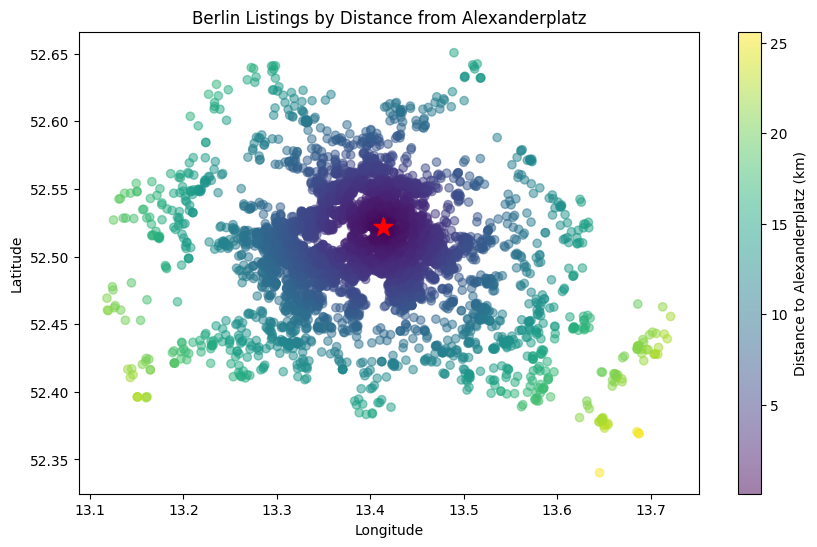

In [8]:
# centre point for refrence to caluate the distance later
CENTER_LAT = 52.521918  # Alexanderplatz latitude
CENTER_LON = 13.413215  # Alexanderplatz longitude

# clean coordinate columns
selected_df['latitude'] = (
    selected_df['latitude']
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)  # Remove non-numeric chars
    .replace('', np.nan)
    .astype(float)
)

selected_df['longitude'] = (
    selected_df['longitude']
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# drop rows with invalid coordinates
print(f"Before cleaning: {len(selected_df)} rows")
selected_df = selected_df.dropna(subset=['latitude', 'longitude'])
print(f"After cleaning: {len(selected_df)} rows")

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in kilometers"""
    R = 6371  # Earth radius in km

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

# create new distance column
selected_df['distance_to_center'] = selected_df.apply(
    lambda row: haversine_distance(
        row['latitude'],
        row['longitude'],
        CENTER_LAT,
        CENTER_LON
    ),
    axis=1
)

# Verify results
print("\nDistance statistics (km):")
print(selected_df['distance_to_center'].describe())

# Visualization
plt.figure(figsize=(10,6))
plt.scatter(
    selected_df['longitude'],
    selected_df['latitude'],
    c=selected_df['distance_to_center'],
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(label='Distance to Alexanderplatz (km)')
plt.scatter(CENTER_LON, CENTER_LAT, c='red', marker='*', s=200)  # Center marker
plt.title('Berlin Listings by Distance from Alexanderplatz')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The visualization here maps all listings on a scatter plot, coloring each point by its distance from the center, with Alexanderplatz marked by a red star.

This creates an intuitive geographic overview of Berlin's Airbnb distribution, allowing us to see spatial clustering and how property locations relate to the city's core.

**1.1.4 Accomodation and Bedrooms**

Here, we plan to create bins for these two variable. The reason for doing so is beacuse the binning is very helpful in this case as it simplifies continuous variables like `accommodates` and `bedrooms` into meaningful categories, making patterns easier to detect.

It helps us alot by reducing the impact of outliers or rare values (e.g., listings with 10+ beds) that could skew the model. For models like OLS and LASSO, binning can also improve interpretability and reduce noise from small variations.

But before doing that, let's first check the maximum and minumum values for both variables.


In [9]:
print(selected_df['accommodates'].value_counts())
print(selected_df['bedrooms'].value_counts())
selected_df['accommodates'].agg(['min', 'max'])
selected_df['bedrooms'].agg(['min', 'max'])

accommodates
2     3719
4     1726
3      922
1      846
6      619
5      446
8      195
7      125
9       57
10      55
12      40
16      24
14      19
11      15
13       9
15       4
Name: count, dtype: int64
bedrooms
1.0     5769
2.0     1624
0.0      646
3.0      572
4.0      152
5.0       33
6.0       12
7.0        4
8.0        2
14.0       1
15.0       1
Name: count, dtype: int64


,bedrooms
min,0.0
max,15.0


So, we can see that there are available places that could accomodate 2-15 people and has bedrooms ranging from 1-15.

Here, we thought of dividing the bins for **accomodates** in the following manner:

Bin 1:  1–2 guests  → solo/couple (Purely based on assumption)

Bin 2:  3–4 guests  → small families/small groups

Bin 3:  5–6 guests  → medium groups

Bin 4:  7–9 guests  → large groups

Bin 5: 10–20 guests → very large groups / event homes


Similarly for **bedrooms**, we can up with the division based on these notions:

Bin 1:  1 bedroom    → studio/small

Bin 2:  2 bedrooms   → small apartment

Bin 3:  3 bedrooms   → family home

Bin 4:  4–5 bedrooms → large homes

Bin 5:  6+ bedrooms  → rare/luxury/event listings


In [10]:
# binning for variable: accomodation
selected_df['accommodates_bin'] = pd.cut(selected_df['accommodates'], bins=[0, 2, 4, 6, 9, 20], labels=False)
selected_df['bedrooms_bin'] = pd.cut(selected_df['bedrooms'], bins=[0, 1, 2, 3, 4, 16], labels=False)
selected_df.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,105.0,True,False,False,False,1.460288,1,0.0
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,180.0,True,False,False,False,1.241648,3,3.0
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,70.0,True,False,False,False,2.985432,0,NaN
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,90.0,True,False,False,False,2.560950,1,0.0
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,25.0,True,False,False,False,3.135740,0,NaN


I had a slight doubt as the bins might be caluated inaccurectly given the 6+ bedroom bins and 10-15 bins or for the bins that might have missing values. But by checking the number of rows (8821) which is the same as earlier, we can confirm that there is no such possible error.

**1.1.5 Host Listings Count**

We decided to include the variable `host_listings_count` to capture differences between individual and professional hosts. Hosts with many listings may represent businesses or property managers, who often have standardized pricing strategies, economies of scale, or offer different amenities. These hosts may also price more competitively or have more consistent quality, which can influence the listing price.

Hence, lets first check the unique observations to decide how we can clean it for the model later.

In [11]:
print(selected_df['host_total_listings_count'].value_counts())
selected_df['host_total_listings_count'].unique()
selected_df['host_total_listings_count'].agg(['min', 'max'])

host_total_listings_count
1.0       2579
2.0       1337
3.0        830
4.0        522
5.0        431
          ... 
699.0        1
30.0         1
1271.0       1
306.0        1
1245.0       1
Name: count, Length: 69, dtype: int64


,host_total_listings_count
min,1.0
max,1448.0


In [12]:
# creating bins
selected_df['host_scale'] = pd.cut(selected_df['host_total_listings_count'], bins=[0, 1, 5, 10, 1149], labels=False)

**1.1.6 Maximum and Minimum Nights**

We decided to use binning for `minimum_nights` and `maximum_nights` to reduce the complexity and skewness in the data, as these variables contain a wide range of values (as shown below) with some extreme outliers.

Binning helps group listings into meaningful categories, such as short-term or long-term stays, making patterns easier to interpret. It also improves model performance by simplifying the feature space and reducing noise from rare or extreme values.

In [13]:
print(selected_df['maximum_nights'].value_counts())
selected_df['maximum_nights'].unique()
selected_df['maximum_nights'].agg(['min', 'max'])

maximum_nights
365     2775
1125    2162
30       408
90       322
60       305
        ... 
320        1
650        1
345        1
545        1
102        1
Name: count, Length: 179, dtype: int64


,maximum_nights
min,1
max,9999


In [14]:
print(selected_df['minimum_nights'].value_counts())
selected_df['minimum_nights'].unique()
selected_df['minimum_nights'].agg(['min', 'max'])

minimum_nights
1      2012
2      1607
92     1432
3      1341
4       481
       ... 
84        1
11        1
227       1
27        1
35        1
Name: count, Length: 88, dtype: int64


,minimum_nights
min,1
max,700


In [15]:
#creating bins for both
selected_df['min_nights_bin'] = pd.cut(selected_df['minimum_nights'], bins=[0, 3, 7, 30, 701], labels=False)
selected_df['max_nights_bin'] = pd.cut(selected_df['maximum_nights'], bins=[0, 7, 30, 100, 10000], labels=False)
selected_df.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,...,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin,host_scale,min_nights_bin,max_nights_bin
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,...,True,False,False,False,1.460288,1,0.0,0.0,3,3
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,...,True,False,False,False,1.241648,3,3.0,0.0,1,1
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,...,True,False,False,False,2.985432,0,NaN,1.0,3,3
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,...,True,False,False,False,2.560950,1,0.0,1.0,3,3
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,...,True,False,False,False,3.135740,0,NaN,1.0,3,3


**1.1.6 Review Number and Review Score Rating**

Let's start by checking the observations for these variables.

In [16]:
print(selected_df['number_of_reviews'].value_counts())
selected_df['number_of_reviews'].unique()
selected_df['number_of_reviews'].agg(['min', 'max'])

number_of_reviews
0      2081
1       498
2       321
3       270
5       240
       ... 
424       1
594       1
670       1
396       1
566       1
Name: count, Length: 483, dtype: int64


,number_of_reviews
min,0
max,2611


In [17]:
print(selected_df['review_scores_rating'].value_counts())
selected_df['review_scores_rating'].unique()
selected_df['review_scores_rating'].agg(['min', 'max'])

review_scores_rating
5.00    1630
4.86     167
4.75     161
4.90     157
4.89     157
        ... 
4.05       1
3.94       1
3.97       1
4.16       1
3.20       1
Name: count, Length: 125, dtype: int64


,review_scores_rating
min,0.0
max,5.0


From the results above we see that the highest rating is 5.0 and the lowest rating could be 0. There is an few observations with nan, we will drop those observation.

Also, `number of reviews` has a large range of observation. We decided to bin `number_of_reviews` to group listings by popularity and experience level. This helps distinguish new or rarely used listings from highly active and well-reviewed ones. It also reduces the effect of outliers and simplifies the model’s interpretation of user engagement levels.

Lets proceed with the code:

In [18]:
# Drop rows where review_scores_rating is missing
selected_df = selected_df.dropna(subset=['number_of_reviews'])
selected_df['review_number'] = pd.cut(selected_df['number_of_reviews'], bins=[0, 100, 200, 300 , 400, 500, 600, 2612], labels=False)
selected_df.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,...,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin,host_scale,min_nights_bin,max_nights_bin,review_number
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,...,False,False,False,1.460288,1,0.0,0.0,3,3,1.0
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,...,False,False,False,1.241648,3,3.0,0.0,1,1,0.0
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,...,False,False,False,2.985432,0,NaN,1.0,3,3,0.0
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,...,False,False,False,2.560950,1,0.0,1.0,3,3,0.0
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,...,False,False,False,3.135740,0,NaN,1.0,3,3,2.0


#**1.2.1 Model: OLS**

In this part, we decided to built and compare three OLS regression models like we did in the last assignment.

We started with a basic model including distance to the city center, review score rating, and number of bedrooms. Then, we gradually added more variables like accommodates, maximum and minimum nights, number of reviews, and host listing count to see how they improve the model.

We used `summary_col` to display all models side by side in a clean summary table.

In [19]:
# Features and Target
X = selected_df.drop('price', axis=1)
y = selected_df['price']

# Keep only numeric variables
X = X.select_dtypes(include=[np.number])

# Filter to Drop NaNs for Required Columns
required_cols = [
    'distance_to_center', 'review_scores_rating', 'bedrooms_bin',
    'accommodates_bin', 'min_nights_bin', 'max_nights_bin', 'host_scale', 'review_number'
]

valid_index = X[required_cols].dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Add constant for OLS intercept
X = sm.add_constant(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Variables for Each Model
model1_vars = ['const', 'distance_to_center', 'review_scores_rating', 'bedrooms_bin']
model2_vars = model1_vars + ['accommodates_bin', 'max_nights_bin', 'min_nights_bin']
model3_vars = model2_vars + ['host_scale', 'review_number']

# Step 6: Fit the Models
model1 = sm.OLS(y_train, X_train[model1_vars]).fit()
model2 = sm.OLS(y_train, X_train[model2_vars]).fit()
model3 = sm.OLS(y_train, X_train[model3_vars]).fit()

# Display Model Comparison Table
summary = summary_col(
    results=[model1, model2, model3],
    float_format='%0.3f',
    stars=True,
    model_names=['Model 1', 'Model 2', 'Model 3'],
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}",
        'BIC': lambda x: f"{x.bic:.0f}",
        'Observations': lambda x: f"{int(x.nobs)}"
    }
)

print(summary)
#selected_df


                      Model 1   Model 2    Model 3  
----------------------------------------------------
const                118.753   30.807     -34.835   
                     (74.458)  (78.011)   (81.225)  
distance_to_center   -7.057*** -6.550***  -6.338*** 
                     (1.321)   (1.317)    (1.332)   
review_scores_rating 8.415     21.807     34.428**  
                     (15.508)  (15.629)   (16.065)  
bedrooms_bin         97.464*** 55.502***  58.538*** 
                     (6.703)   (9.752)    (9.792)   
accommodates_bin               42.774***  38.284*** 
                               (7.580)    (7.737)   
max_nights_bin                 7.113      3.957     
                               (5.815)    (5.857)   
min_nights_bin                 -21.261*** -22.118***
                               (5.160)    (5.197)   
host_scale                                17.832*** 
                                          (5.220)   
review_number                             -16

**Basic Interpretation**

The results show that model fit slightly improves as more variables are added, with R² increasing from 0.046 in Model 1 to 0.063 in Model 3.

Across all models, distance to center and bedrooms_bin have strong and significant effects, with more bedrooms increasing price and distance decreasing it.

In Models 2 and 3, `accommodates_bin` and `min_nights_bin` are also significant, suggesting that capacity and stay duration play a role in pricing.

Model 3 introduces host scale and number of reviews, both statistically significant, indicating hosts with more listings and fewer reviews tend to charge higher prices. Despite statistical significance, the models still explain only a small portion of price variation.

Overall, Model 3 performs best in terms of fit and explanatory power.

#**1.2.2 Model: LASSO**

Here, we use the `LassoCV` from `sklearn` to automatically select the best regularization strength through cross-validation. We scaled the features using `StandardScaler` to ensure fair penalty application across variables.

After fitting the model on the training data, we print the selected alpha value and the coefficients for each feature.

And then we proceed on to evaluate the model’s performance on the test set using R² and RMSE to measure how well it predicts Airbnb prices.

In [20]:
# Drop rows with NaNs
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:

# Build LASSO Pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# Fit LASSO
lasso_pipeline.fit(X_train, y_train)

# Get Best Alpha and Coefficients
best_alpha = lasso_pipeline.named_steps['lasso'].alpha_
lasso_coefficients = lasso_pipeline.named_steps['lasso'].coef_

print(f"Best alpha (lambda): {best_alpha:.4f}")
print("\nLASSO Coefficients:")
for feature, coef in zip(X.columns, lasso_coefficients):
    print(f"{feature}: {coef:.4f}")

# Evaluate Model
y_pred = lasso_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nTest R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.2f}")

Best alpha (lambda): 0.3294

LASSO Coefficients:
const: 0.0000
latitude: -5.0031
longitude: -4.4957
accommodates: 45.9466
bedrooms: 34.8731
host_total_listings_count: 0.0000
maximum_nights: -4.0020
minimum_nights: -5.0797
number_of_reviews: -26.6393
review_scores_rating: 10.8960
distance_to_center: -26.6460
accommodates_bin: -0.0000
bedrooms_bin: 4.3887
host_scale: 17.4272
min_nights_bin: -18.1715
max_nights_bin: 4.6817
review_number: 9.7183

Test R²: 0.3462
Test RMSE: 117.75


**Basic Interpretation**

The RMSE of 117.75 suggests much more accurate predictions. LASSO also automatically set several coefficients to zero, such as `host_total_listings_count` and `accommodates_bin`, indicating they had little predictive value.

Key predictors included `accommodates_bin`, `bedrooms_bin`, `distance to center`, and `review_scores_rating`.

Notably, host scale and review number also contributed positively to price. The regularization helped remove noise and focus on truly influential variables, leading to better model performance.

#**1.2.3 Model: Random Forest**

In this part, we trained a Random Forest regression model to predict Airbnb prices using all numeric features. We split the data into training and test sets, fit the model, and evaluated its performance using R² and RMSE. We also extracted and ranked feature importances to understand which variables contributed most to the model's predictions. This helps interpret the model and compare it with previous approaches like OLS and LASSO.

In [22]:
# Select Relevant Features
selected_features = [
    'distance_to_center', 'review_scores_rating', 'bedrooms_bin',
    'accommodates_bin', 'min_nights_bin', 'max_nights_bin',
    'host_scale', 'review_number'
]

X = selected_df[selected_features]
y = selected_df['price']
# Drop NaNs and Split Data
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest Test R²: {r2:.4f}")
print(f"Random Forest Test RMSE: {rmse:.2f}")

# Show Feature Importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))

Random Forest Test R²: -5.0023
Random Forest Test RMSE: 356.78

Top Features by Importance:
                Feature  Importance
0    distance_to_center    0.663847
3      accommodates_bin    0.110469
2          bedrooms_bin    0.070441
1  review_scores_rating    0.064628
6            host_scale    0.037093
4        min_nights_bin    0.024699
5        max_nights_bin    0.019488
7         review_number    0.009336


**Basic Intepretation**

 This Random Forest model has a Test R² of -5.0023, indicating that its predictions are significantly worse than simply predicting the mean price.

 The high RMSE of 356.78 further confirms poor predictive accuracy. Despite the poor fit, the model ranked distance_to_center as by far the most important feature, contributing over 67% of the decision weight.

 Other features like accommodates_bin, number_of_reviews, and bedrooms_bin had some influence but much less impact. The negative R² suggests overfitting or that the model struggles with the structure of the binned input data.

#**1.2.4 Model: XGBoost**

Here, for out fourth model, we choose XGBoost model. We trained the model on numeric features from the dataset and evaluated its performance using R² and RMSE on the test set.

After fitting, we also extracted and ranked the most important features based on their contribution to the model.

In [23]:
# Keep only numeric columns and drop NaNs
X = X.select_dtypes(include='number')
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Fit XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost Test R²: {r2:.4f}")
print(f"XGBoost Test RMSE: {rmse:.2f}")

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


XGBoost Test R²: -6.1240
XGBoost Test RMSE: 388.69

Top Features by Importance:
                Feature  Importance
6            host_scale    0.573889
0    distance_to_center    0.161075
1  review_scores_rating    0.135440
3      accommodates_bin    0.081807
2          bedrooms_bin    0.024549
4        min_nights_bin    0.012217
5        max_nights_bin    0.006598
7         review_number    0.004425


**Basic Interpretation**

This XGBoost model performed very poorly, with a test R² of -6.12, indicating predictions are far worse than the average-based baseline.

The RMSE is also quite high at 388.69, suggesting large errors. Interestingly, the most influential feature by far was host_scale, contributing nearly 57% to the model's decision-making, followed by distance_to_center and review_scores_rating.

Other variables had minimal influence, and review_number was nearly irrelevant. The results suggest that the model may be overfitting or reacting too strongly to one variable.

#**1.2.5 Model: LightGBM**

In this part, we use LightGBM as out fifth model.

We evaluated its performance using R² and RMSE, and analyzed which features were most important for prediction. This helped us assess how well LightGBM captures complex patterns in the data compared to other models like Random Forest and XGBoost.

In [24]:
# Fit LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"LightGBM Test R²: {r2:.4f}")
print(f"LightGBM Test RMSE: {rmse:.2f}")

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 4969, number of used features: 8
[LightGBM] [Info] Start training from score 163.402294
LightGBM Test R²: -0.2185
LightGBM Test RMSE: 160.75

Top Features by Importance:
                Feature  Importance
0    distance_to_center        1302
1  review_scores_rating         617
3      accommodates_bin         255
2          bedrooms_bin         249
6            host_scale         237
4        min_nights_bin         157
5        max_nights_bin         107
7         review_number          76


**Basic Interpretation**

This LightGBM model had a Test R² of -0.2185, meaning it performed slightly worse than predicting the mean price, though not as poorly as some other models.

The RMSE of 160.75 indicates a moderate prediction error. The most influential feature was distance_to_center, followed by review_scores_rating and accommodates_bin, confirming the importance of location, guest satisfaction, and capacity. Features like review_number and max_nights_bin contributed very little.

# **1.3.1 Horserace table -- Model Comparasion**




Here, we compare the performance of five different regression models—OLS, LASSO, Random Forest, XGBoost, and LightGBM—on predicting Airbnb prices.

For each model, we record its R² score, RMSE, and training time. These results are then compiled into a horserace table to evaluate which model fits the data best and which one trains fastest.

In [25]:
results = []
# OLS
start = time.time()
lr_model = LinearRegression().fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
end = time.time()
results.append(['OLS', r2_score(y_test, lr_pred), np.sqrt(mean_squared_error(y_test, lr_pred)), end - start])

# LASSO
start = time.time()
lasso = LassoCV(cv=5).fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
end = time.time()
results.append(['LASSO', r2_score(y_test, lasso_pred), np.sqrt(mean_squared_error(y_test, lasso_pred)), end - start])

# Random Forest
start = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
rf_pred = rf.predict(X_test)
end = time.time()
results.append(['Random Forest', r2_score(y_test, rf_pred), np.sqrt(mean_squared_error(y_test, rf_pred)), end - start])

# XGBoost
start = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0).fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
end = time.time()
results.append(['XGBoost', r2_score(y_test, xgb_pred), np.sqrt(mean_squared_error(y_test, xgb_pred)), end - start])

# LightGBM
start = time.time()
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42).fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
end = time.time()
results.append(['LightGBM', r2_score(y_test, lgb_pred), np.sqrt(mean_squared_error(y_test, lgb_pred)), end - start])

# Horserace Table
horse_df = pd.DataFrame(results, columns=['Model', 'R² Score', 'RMSE', 'Train Time (s)'])
horse_df.sort_values(by='R² Score', ascending=False, inplace=True)
print("\nModel Comparison (Horserace Table):")
print(horse_df.to_string(index=False))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 4969, number of used features: 8
[LightGBM] [Info] Start training from score 163.402294

Model Comparison (Horserace Table):
        Model   R² Score       RMSE  Train Time (s)
        LASSO   0.351286 117.292170        0.201843
          OLS   0.351106 117.308492        0.023602
     LightGBM  -0.218501 160.751656        0.162495
Random Forest  -5.002305 356.780830        5.880777
      XGBoost -14.765666 578.227382        0.852458


The horserace table shows that LASSO and OLS performed best, both achieving an R² of around 0.35 and the lowest RMSE (~117), indicating strong and consistent predictive power. Although an -squared of 35 percent is still very low.

LightGBM came next, but with a negative R² (-0.22), its predictions were worse than simply guessing the average, despite a decent RMSE. Random Forest and XGBoost performed very poorly, with large negative R² values and high RMSEs, suggesting overfitting or poor generalization.

Overall, simpler linear models outperformed more complex ones in this case.

# **1.4.1 Feature Importance: RF and LightGBM**


Here, we extracted feature importance values from both the Random Forest and LightGBM models. We then select the top 10 features from each and merge them into a single comparison table.

In [26]:
# Extract feature importances
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF Importance': rf.feature_importances_
}).sort_values(by='RF Importance', ascending=False).reset_index(drop=True)

lgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'LightGBM Importance': lgb_model.feature_importances_
}).sort_values(by='LightGBM Importance', ascending=False).reset_index(drop=True)

# Merge Top 10 from each
rf_top10 = rf_importance.head(10)
lgb_top10 = lgb_importance.head(10)

# Merge on feature name for comparison
comparison_df = pd.merge(rf_top10, lgb_top10, on='Feature', how='outer').fillna(0)
comparison_df = comparison_df.sort_values(by='RF Importance', ascending=False).reset_index(drop=True)
print("Top 10 Feature Importance Comparison (RF vs LightGBM):")
print(comparison_df.to_string(index=False))


Top 10 Feature Importance Comparison (RF vs LightGBM):
             Feature  RF Importance  LightGBM Importance
  distance_to_center       0.663847                 1302
    accommodates_bin       0.110469                  255
        bedrooms_bin       0.070441                  249
review_scores_rating       0.064628                  617
          host_scale       0.037093                  237
      min_nights_bin       0.024699                  157
      max_nights_bin       0.019488                  107
       review_number       0.009336                   76


This feature importance comparison shows that both Random Forest and LightGBM agree on the most influential variable: distance_to_center, which dominates in both models.

Other shared key features include accommodates_bin, bedrooms_bin, and review_scores_rating, suggesting that property size, quality, and location are consistently important for predicting price.

While the scale of importance values differs (RF gives normalized values, LightGBM gives frequency-based scores), the relative rankings are largely similar.

This consistency supports the reliability of these features, even though the overall model performance was weak.

# **Part 2: Validity**

Now, we will take Berlin dataset for the month of December.

# **2.1 Data Wrangling: Berlin (June)**

In [27]:
berlin_dec=pd.read_csv('Berlin_listings_December.csv')
print(berlin_dec.shape)
berlin_dec.head()
berlin_dec.columns

(13984, 75)


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [28]:
# Select only the variables of interest
selected_columns_dec = [
    'room_type',
    'latitude',
    'longitude',
    'accommodates',
    'bedrooms',
    'host_total_listings_count',
    'maximum_nights',
    'minimum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'price'
]

# Create new dataframe with only selected variables
selected_dec = airbnb[selected_columns_dec].copy()
print(selected_dec.shape)
print(selected_dec.dtypes)
selected_dec.head()

(13759, 11)
room_type                     object
latitude                     float64
longitude                    float64
accommodates                   int64
bedrooms                     float64
host_total_listings_count    float64
maximum_nights                 int64
minimum_nights                 int64
number_of_reviews              int64
review_scores_rating         float64
price                         object
dtype: object


,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price
0,Entire home/apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,$105.00
1,Entire home/apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,$180.00
2,Entire home/apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,$70.00
3,Entire home/apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,$90.00
4,Entire home/apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,$25.00


**2.1.1. Price**


In [29]:
# Convert price column to float
selected_dec['price'] = (
    selected_dec['price']
    .astype(str)  # ensure everything is treated as string
    .str.replace('[\$,]', '', regex=True)  # Remove both $ and commas
    .astype(float)
)

print(selected_dec['price'].head())

# Drop rows with missing prices
selected_dec = selected_dec.dropna(subset=['price'])
print("\nMissing values after cleaning:", selected_dec['price'].isnull().sum())

0    105.0
1    180.0
2     70.0
3     90.0
4     25.0
Name: price, dtype: float64

Missing values after cleaning: 0


**2.1.2 Room Type**

In [30]:
# Clean the room_type strings
selected_dec['room_type'] = (
    selected_dec['room_type']
    .str.strip()
    .str.lower()
    .str.replace(r'[\/\s]', '_', regex=True)
)

# Create dummy variables
dummies = pd.get_dummies(
    selected_dec['room_type'],
    prefix='room',
    drop_first=False
)

# Join with original data
selected_dec = pd.concat([selected_dec, dummies], axis=1)

# Preview the dummy variables
print(selected_dec.filter(like='room_').head())
selected_dec.head()


         room_type  room_entire_home_apt  room_hotel_room  room_private_room  \
0  entire_home_apt                  True            False              False   
1  entire_home_apt                  True            False              False   
2  entire_home_apt                  True            False              False   
3  entire_home_apt                  True            False              False   
4  entire_home_apt                  True            False              False   

   room_shared_room  
0             False  
1             False  
2             False  
3             False  
4             False  


,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,105.0,True,False,False,False
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,180.0,True,False,False,False
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,70.0,True,False,False,False
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,90.0,True,False,False,False
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,25.0,True,False,False,False


**2.1.3 Latitude and Longitude**

Before cleaning: 8821 rows
After cleaning: 8821 rows

Distance statistics (km):
count    8821.000000
mean        5.250091
std         3.864377
min         0.072500
25%         2.652473
50%         4.148476
75%         6.695547
max        25.616623
Name: distance_to_center, dtype: float64


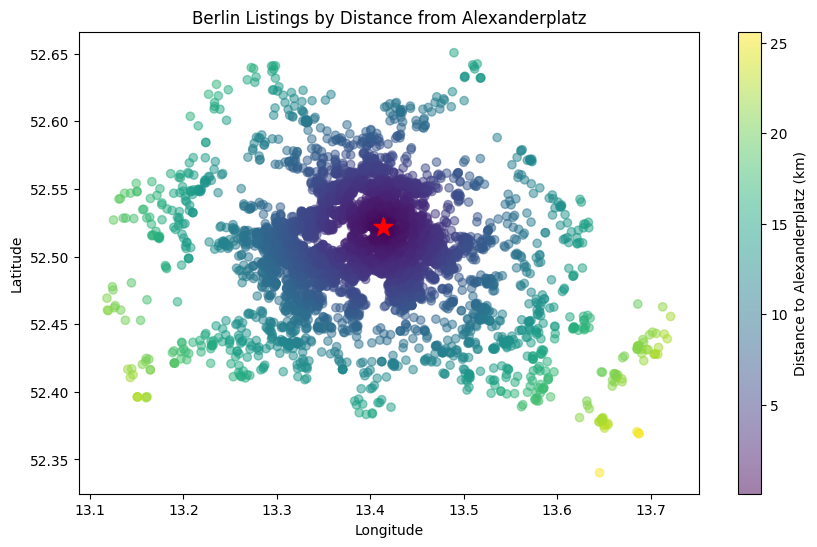

In [31]:
# Centre point for reference (Alexanderplatz)
CENTER_LAT = 52.521918
CENTER_LON = 13.413215

# Clean coordinate columns
selected_dec['latitude'] = (
    selected_dec['latitude']
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

selected_dec['longitude'] = (
    selected_dec['longitude']
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# Drop rows with invalid coordinates
print(f"Before cleaning: {len(selected_dec)} rows")
selected_dec = selected_dec.dropna(subset=['latitude', 'longitude'])
print(f"After cleaning: {len(selected_dec)} rows")

# Haversine formula to calculate distance to center
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Create new distance column
selected_dec['distance_to_center'] = selected_dec.apply(
    lambda row: haversine_distance(
        row['latitude'],
        row['longitude'],
        CENTER_LAT,
        CENTER_LON
    ),
    axis=1
)

# Summary stats
print("\nDistance statistics (km):")
print(selected_dec['distance_to_center'].describe())

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    selected_dec['longitude'],
    selected_dec['latitude'],
    c=selected_dec['distance_to_center'],
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(label='Distance to Alexanderplatz (km)')
plt.scatter(CENTER_LON, CENTER_LAT, c='red', marker='*', s=200)  # Center marker
plt.title('Berlin Listings by Distance from Alexanderplatz')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


**2.1.4 Accomodation and Bedrooms**

In [32]:
selected_dec['accommodates'].agg(['min', 'max'])

,accommodates
min,1
max,16


In [33]:
selected_dec['bedrooms'].agg(['min', 'max'])

,bedrooms
min,0.0
max,15.0


In [34]:
# binning for variable: accomodation
selected_dec['accommodates_bin'] = pd.cut(selected_dec['accommodates'], bins=[0, 2, 4, 6, 9, 16], labels=False)
selected_dec['bedrooms_bin'] = pd.cut(selected_dec['bedrooms'], bins=[0, 1, 2, 3, 4, 15], labels=False)
# selected_dec.head()

**2.1.5 Host Listings Count**

In [35]:
selected_dec['host_total_listings_count'].agg(['min', 'max'])

,host_total_listings_count
min,1.0
max,1448.0


In [36]:
#creating bins
selected_dec['host_scale'] = pd.cut(selected_dec['host_total_listings_count'], bins=[0, 1, 5, 10, 1149], labels=False)

**2.1.6 Maximum and Minimum Nights**

In [37]:
selected_dec['maximum_nights'].agg(['min', 'max'])

,maximum_nights
min,1
max,9999


In [38]:
selected_dec['minimum_nights'].agg(['min', 'max'])

,minimum_nights
min,1
max,700


In [39]:
#creating bins for both
selected_dec['min_nights_bin'] = pd.cut(selected_dec['minimum_nights'], bins=[0, 3, 7, 30, 701], labels=False)
selected_dec['max_nights_bin'] = pd.cut(selected_dec['maximum_nights'], bins=[0, 7, 30, 100, 10000], labels=False)
selected_dec.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,...,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin,host_scale,min_nights_bin,max_nights_bin
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,...,True,False,False,False,1.460288,1,0.0,0.0,3,3
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,...,True,False,False,False,1.241648,3,3.0,0.0,1,1
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,...,True,False,False,False,2.985432,0,NaN,1.0,3,3
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,...,True,False,False,False,2.560950,1,0.0,1.0,3,3
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,...,True,False,False,False,3.135740,0,NaN,1.0,3,3


**2.1.7 Review Number and Review Score Rating**

In [40]:
selected_dec['number_of_reviews'].agg(['min', 'max'])

,number_of_reviews
min,0
max,2611


In [41]:
# Drop rows where review_scores_rating is missing
selected_dec = selected_dec.dropna(subset=['number_of_reviews'])
selected_dec['review_number'] = pd.cut(selected_dec['number_of_reviews'], bins=[0, 100, 200, 300 , 400, 500, 600, 2612], labels=False)
selected_dec.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,...,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin,host_scale,min_nights_bin,max_nights_bin,review_number
0,entire_home_apt,52.53471,13.41810,4,1.0,1.0,365,63,148,4.63,...,False,False,False,1.460288,1,0.0,0.0,3,3,1.0
1,entire_home_apt,52.53269,13.41805,7,4.0,1.0,14,6,7,5.00,...,False,False,False,1.241648,3,3.0,0.0,1,1,0.0
2,entire_home_apt,52.54813,13.40366,1,0.0,5.0,1125,150,26,4.68,...,False,False,False,2.985432,0,NaN,1.0,3,3,0.0
3,entire_home_apt,52.50312,13.43508,4,1.0,4.0,365,93,48,4.72,...,False,False,False,2.560950,1,0.0,1.0,3,3,0.0
4,entire_home_apt,52.49419,13.42166,2,0.0,5.0,365,92,299,4.77,...,False,False,False,3.135740,0,NaN,1.0,3,3,2.0


#**2.2.1 Model: OLS- June**

In [42]:
# Features and Target
X = selected_dec.drop('price', axis=1)
y = selected_dec['price']

# Keep only numeric variables
X = X.select_dtypes(include=[np.number])

# Filter to Drop NaNs for Required Columns
required_cols = [
    'distance_to_center', 'review_scores_rating', 'bedrooms_bin',
    'accommodates_bin', 'min_nights_bin', 'max_nights_bin', 'host_scale', 'review_number'
]

valid_index = X[required_cols].dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Add constant for OLS intercept
X = sm.add_constant(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Variables for Each Model
model1_vars = ['const', 'distance_to_center', 'review_scores_rating', 'bedrooms_bin']
model2_vars = model1_vars + ['accommodates_bin', 'max_nights_bin', 'min_nights_bin']
model3_vars = model2_vars + ['host_scale', 'review_number']

# Step 6: Fit the Models
model1 = sm.OLS(y_train, X_train[model1_vars]).fit()
model2 = sm.OLS(y_train, X_train[model2_vars]).fit()
model3 = sm.OLS(y_train, X_train[model3_vars]).fit()

# Display Model Comparison Table
summary = summary_col(
    results=[model1, model2, model3],
    float_format='%0.3f',
    stars=True,
    model_names=['Model 1', 'Model 2', 'Model 3'],
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}",
        'BIC': lambda x: f"{x.bic:.0f}",
        'Observations': lambda x: f"{int(x.nobs)}"
    }
)

print(summary)



                      Model 1   Model 2    Model 3  
----------------------------------------------------
const                118.753   30.807     -34.835   
                     (74.458)  (78.011)   (81.225)  
distance_to_center   -7.057*** -6.550***  -6.338*** 
                     (1.321)   (1.317)    (1.332)   
review_scores_rating 8.415     21.807     34.428**  
                     (15.508)  (15.629)   (16.065)  
bedrooms_bin         97.464*** 55.502***  58.538*** 
                     (6.703)   (9.752)    (9.792)   
accommodates_bin               42.774***  38.284*** 
                               (7.580)    (7.737)   
max_nights_bin                 7.113      3.957     
                               (5.815)    (5.857)   
min_nights_bin                 -21.261*** -22.118***
                               (5.160)    (5.197)   
host_scale                                17.832*** 
                                          (5.220)   
review_number                             -16

#**2.2.2 Model: LASSO**


In [43]:
# Drop rows with NaNs
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:

# Build LASSO Pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# Fit LASSO
lasso_pipeline.fit(X_train, y_train)

# Get Best Alpha and Coefficients
best_alpha = lasso_pipeline.named_steps['lasso'].alpha_
lasso_coefficients = lasso_pipeline.named_steps['lasso'].coef_

print(f"Best alpha (lambda): {best_alpha:.4f}")
print("\nLASSO Coefficients:")
for feature, coef in zip(X.columns, lasso_coefficients):
    print(f"{feature}: {coef:.4f}")

# Evaluate Model
y_pred = lasso_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nTest R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.2f}")

Best alpha (lambda): 0.3294

LASSO Coefficients:
const: 0.0000
latitude: -5.0031
longitude: -4.4957
accommodates: 45.9466
bedrooms: 34.8731
host_total_listings_count: 0.0000
maximum_nights: -4.0020
minimum_nights: -5.0797
number_of_reviews: -26.6393
review_scores_rating: 10.8960
distance_to_center: -26.6460
accommodates_bin: -0.0000
bedrooms_bin: 4.3887
host_scale: 17.4272
min_nights_bin: -18.1715
max_nights_bin: 4.6817
review_number: 9.7183

Test R²: 0.3462
Test RMSE: 117.75


#**2.2.3 Model: Random Forest**

In [45]:
# Select Relevant Features
selected_features = [
    'distance_to_center', 'review_scores_rating', 'bedrooms_bin',
    'accommodates_bin', 'min_nights_bin', 'max_nights_bin',
    'host_scale', 'review_number'
]

X = selected_dec[selected_features]
y = selected_dec['price']

# Drop NaNs and Split Data
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest Test R²: {r2:.4f}")
print(f"Random Forest Test RMSE: {rmse:.2f}")

# Show Feature Importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


Random Forest Test R²: -5.0023
Random Forest Test RMSE: 356.78

Top Features by Importance:
                Feature  Importance
0    distance_to_center    0.663847
3      accommodates_bin    0.110469
2          bedrooms_bin    0.070441
1  review_scores_rating    0.064628
6            host_scale    0.037093
4        min_nights_bin    0.024699
5        max_nights_bin    0.019488
7         review_number    0.009336


#**2.2.4 Model: XGBoost**

In [46]:
# Keep only numeric columns and drop NaNs
X = X.select_dtypes(include='number')
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Fit XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost Test R²: {r2:.4f}")
print(f"XGBoost Test RMSE: {rmse:.2f}")

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


XGBoost Test R²: -6.1240
XGBoost Test RMSE: 388.69

Top Features by Importance:
                Feature  Importance
6            host_scale    0.573889
0    distance_to_center    0.161075
1  review_scores_rating    0.135440
3      accommodates_bin    0.081807
2          bedrooms_bin    0.024549
4        min_nights_bin    0.012217
5        max_nights_bin    0.006598
7         review_number    0.004425


#**1.2.5 Model: LightGBM**

In [47]:
# Fit LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"LightGBM Test R²: {r2:.4f}")
print(f"LightGBM Test RMSE: {rmse:.2f}")

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 386
[LightGBM] [Info] Number of data points in the train set: 4969, number of used features: 8
[LightGBM] [Info] Start training from score 163.402294
LightGBM Test R²: -0.2185
LightGBM Test RMSE: 160.75

Top Features by Importance:
                Feature  Importance
0    distance_to_center        1302
1  review_scores_rating         617
3      accommodates_bin         255
2          bedrooms_bin         249
6            host_scale         237
4        min_nights_bin         157
5        max_nights_bin         107
7         review_number          76


# 3. Munich

# 3.1 Data Wrangling

We will follow the same procedire as before:

In [48]:
airbnb_1=pd.read_csv('Munich_listings_June.csv')
print(airbnb_1.shape)
airbnb_1.head()
airbnb_1.columns

(6746, 75)


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [49]:
airbnb_1['host_listings_count']

,host_listings_count
0,2.0
1,3.0
2,2.0
3,1.0
4,1.0
...,...
6741,1.0
6742,1.0
6743,1.0
6744,1.0


In [50]:
# Select only the variables of interest
selected_columns_Munich = [
    'room_type',
    'latitude',
    'longitude',
    'accommodates',
    'bedrooms',
    'host_total_listings_count',
    'maximum_nights',
    'minimum_nights',
    'number_of_reviews',
    'review_scores_rating',
    'price'
]

# Create new dataframe with only selected variables
selected_Munich = airbnb_1[selected_columns_Munich].copy()
print(selected_Munich.shape)
print(selected_Munich.dtypes)
selected_Munich.head()

(6746, 11)
room_type                     object
latitude                     float64
longitude                    float64
accommodates                   int64
bedrooms                     float64
host_total_listings_count    float64
maximum_nights                 int64
minimum_nights                 int64
number_of_reviews              int64
review_scores_rating         float64
price                         object
dtype: object


,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price
0,Entire home/apt,48.11492,11.48954,2,1.0,3.0,90,2,127,4.84,$95.00
1,Entire home/apt,48.12071,11.63758,5,1.0,3.0,30,2,69,4.82,$105.00
2,Entire home/apt,48.15199,11.56482,4,1.0,2.0,20,3,112,4.83,NaN
3,Entire home/apt,48.13855,11.46586,2,1.0,1.0,35,4,40,4.66,$76.00
4,Private room,48.10814,11.52733,4,1.0,1.0,1125,3,559,4.95,$70.00


**Price**

In [51]:
# Convert price column to float
selected_Munich['price'] = (
    selected_Munich['price']
    .astype(str)  # ensure everything is treated as string
    .str.replace('[\$,]', '', regex=True)  # Remove both $ and commas
    .astype(float)
)

print(selected_df['price'].head())

# Drop rows with missing prices
selected_Munich = selected_Munich.dropna(subset=['price'])
print("\nMissing values after cleaning:", selected_Munich['price'].isnull().sum())

0    105.0
1    180.0
2     70.0
3     90.0
4     25.0
Name: price, dtype: float64

Missing values after cleaning: 0


**Room Type**

In [52]:
# First, let's examine the current values
print("Current room_type values:")
print(selected_Munich['room_type'].value_counts())

# Clean the room_type strings
selected_Munich['room_type'] = (
    selected_Munich['room_type']
    .str.strip()
    .str.lower()
    .str.replace(r'[\/\s]', '_', regex=True)
)

# Create dummy variables
dummies = pd.get_dummies(
    selected_Munich['room_type'],
    prefix='room',
    drop_first=False
)

# Join with original data
selected_Munich = pd.concat([selected_Munich, dummies], axis=1)
print(selected_Munich.filter(like='room_').head())
selected_Munich.head()
#print(selected_df.shape)

Current room_type values:
room_type
Entire home/apt    3043
Private room       1536
Shared room          37
Hotel room           18
Name: count, dtype: int64
         room_type  room_entire_home_apt  room_hotel_room  room_private_room  \
0  entire_home_apt                  True            False              False   
1  entire_home_apt                  True            False              False   
3  entire_home_apt                  True            False              False   
4     private_room                 False            False               True   
7     private_room                 False            False               True   

   room_shared_room  
0             False  
1             False  
3             False  
4             False  
7             False  


,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room
0,entire_home_apt,48.11492,11.48954,2,1.0,3.0,90,2,127,4.84,95.0,True,False,False,False
1,entire_home_apt,48.12071,11.63758,5,1.0,3.0,30,2,69,4.82,105.0,True,False,False,False
3,entire_home_apt,48.13855,11.46586,2,1.0,1.0,35,4,40,4.66,76.0,True,False,False,False
4,private_room,48.10814,11.52733,4,1.0,1.0,1125,3,559,4.95,70.0,False,False,True,False
7,private_room,48.14957,11.55507,2,1.0,1.0,7,2,105,4.85,98.0,False,False,True,False


**Latitude and Longitude**

Before cleaning: 4634 rows
After cleaning: 4634 rows

Distance statistics (km):
count    4634.000000
mean        4.186817
std         2.725592
min         0.130498
25%         2.114412
50%         3.456702
75%         5.668930
max        14.448039
Name: distance_to_center, dtype: float64


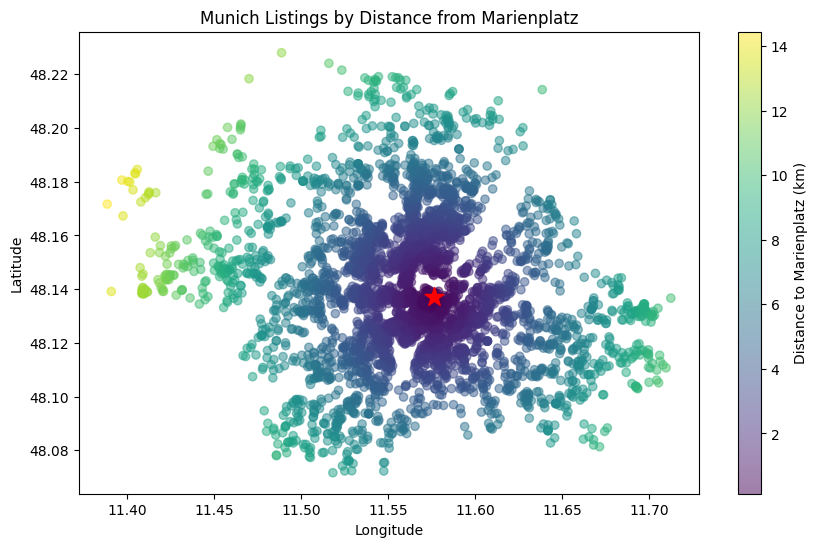

In [53]:
# Centre point for reference to calculate the distance later (Marienplatz, Munich)
CENTER_LAT = 48.137154  # Munich latitude
CENTER_LON = 11.576124  # Munich longitude

# Clean coordinate columns
selected_Munich['latitude'] = (
    selected_Munich['latitude']
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)  # Remove non-numeric chars
    .replace('', np.nan)
    .astype(float)
)

selected_Munich['longitude'] = (
    selected_Munich['longitude']
    .astype(str)
    .str.replace('[^0-9.-]', '', regex=True)
    .replace('', np.nan)
    .astype(float)
)

# Drop rows with invalid coordinates
print(f"Before cleaning: {len(selected_Munich)} rows")
selected_Munich = selected_Munich.dropna(subset=['latitude', 'longitude'])
print(f"After cleaning: {len(selected_Munich)} rows")

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points in kilometers"""
    R = 6371  # Earth radius in km

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

# Create new distance column
selected_Munich['distance_to_center'] = selected_Munich.apply(
    lambda row: haversine_distance(
        row['latitude'],
        row['longitude'],
        CENTER_LAT,
        CENTER_LON
    ),
    axis=1
)

# Verify results
print("\nDistance statistics (km):")
print(selected_Munich['distance_to_center'].describe())

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    selected_Munich['longitude'],
    selected_Munich['latitude'],
    c=selected_Munich['distance_to_center'],
    cmap='viridis',
    alpha=0.5
)
plt.colorbar(label='Distance to Marienplatz (km)')
plt.scatter(CENTER_LON, CENTER_LAT, c='red', marker='*', s=200)  # Center marker
plt.title('Munich Listings by Distance from Marienplatz')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


**3.1.4 Accomodation and Bedrooms**


In [54]:
selected_Munich['bedrooms'].agg(['min', 'max'])

,bedrooms
min,0.0
max,8.0


In [55]:
selected_Munich['accommodates'].agg(['min', 'max'])


,accommodates
min,1
max,16


In [56]:
# binning for variable: accomodation and bedroom
selected_Munich['accommodates_bin'] = pd.cut(selected_Munich['accommodates'], bins=[0, 2, 4, 6, 9, 17], labels=False)
selected_Munich['bedrooms_bin'] = pd.cut(selected_Munich['bedrooms'], bins=[0, 1, 2, 3, 4, 9], labels=False)
selected_Munich.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,price,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin
0,entire_home_apt,48.11492,11.48954,2,1.0,3.0,90,2,127,4.84,95.0,True,False,False,False,6.885592,0,0.0
1,entire_home_apt,48.12071,11.63758,5,1.0,3.0,30,2,69,4.82,105.0,True,False,False,False,4.913987,2,0.0
3,entire_home_apt,48.13855,11.46586,2,1.0,1.0,35,4,40,4.66,76.0,True,False,False,False,8.183601,0,0.0
4,private_room,48.10814,11.52733,4,1.0,1.0,1125,3,559,4.95,70.0,False,False,True,False,4.850366,1,0.0
7,private_room,48.14957,11.55507,2,1.0,1.0,7,2,105,4.85,98.0,False,False,True,False,2.084786,0,0.0


**3.1.5 Host Listings Count**


In [57]:
selected_Munich['host_total_listings_count'].agg(['min', 'max'])

,host_total_listings_count
min,1.0
max,912.0


In [58]:
# creating bins
selected_Munich['host_scale'] = pd.cut(selected_Munich['host_total_listings_count'], bins=[0, 1, 5, 10, 913], labels=False)

**3.1.6 Maximum and Minimum Nights**


In [59]:
selected_Munich['maximum_nights'].agg(['min', 'max'])

,maximum_nights
min,1
max,1125


In [60]:
selected_Munich['minimum_nights'].agg(['min', 'max'])

,minimum_nights
min,1
max,430


In [61]:
#creating bins for both
selected_Munich['min_nights_bin'] = pd.cut(selected_Munich['minimum_nights'], bins=[0, 3, 7, 30, 431], labels=False)
selected_Munich['max_nights_bin'] = pd.cut(selected_Munich['maximum_nights'], bins=[0, 7, 30, 100, 1130], labels=False)
selected_Munich.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,...,room_entire_home_apt,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin,host_scale,min_nights_bin,max_nights_bin
0,entire_home_apt,48.11492,11.48954,2,1.0,3.0,90,2,127,4.84,...,True,False,False,False,6.885592,0,0.0,1.0,0,2
1,entire_home_apt,48.12071,11.63758,5,1.0,3.0,30,2,69,4.82,...,True,False,False,False,4.913987,2,0.0,1.0,0,1
3,entire_home_apt,48.13855,11.46586,2,1.0,1.0,35,4,40,4.66,...,True,False,False,False,8.183601,0,0.0,0.0,1,2
4,private_room,48.10814,11.52733,4,1.0,1.0,1125,3,559,4.95,...,False,False,True,False,4.850366,1,0.0,0.0,0,3
7,private_room,48.14957,11.55507,2,1.0,1.0,7,2,105,4.85,...,False,False,True,False,2.084786,0,0.0,0.0,0,0


**3.1.6 Review Number and Review Score Rating**

In [62]:
selected_Munich['number_of_reviews'].agg(['min', 'max'])

,number_of_reviews
min,0
max,1955


In [63]:
# Drop rows where review_scores_rating is missing
selected_Munich = selected_Munich.dropna(subset=['number_of_reviews'])
selected_Munich['review_number'] = pd.cut(selected_Munich['number_of_reviews'], bins=[0, 100, 200, 300 , 400, 500, 600, 2612], labels=False)
selected_Munich.head()

,room_type,latitude,longitude,accommodates,bedrooms,host_total_listings_count,maximum_nights,minimum_nights,number_of_reviews,review_scores_rating,...,room_hotel_room,room_private_room,room_shared_room,distance_to_center,accommodates_bin,bedrooms_bin,host_scale,min_nights_bin,max_nights_bin,review_number
0,entire_home_apt,48.11492,11.48954,2,1.0,3.0,90,2,127,4.84,...,False,False,False,6.885592,0,0.0,1.0,0,2,1.0
1,entire_home_apt,48.12071,11.63758,5,1.0,3.0,30,2,69,4.82,...,False,False,False,4.913987,2,0.0,1.0,0,1,0.0
3,entire_home_apt,48.13855,11.46586,2,1.0,1.0,35,4,40,4.66,...,False,False,False,8.183601,0,0.0,0.0,1,2,0.0
4,private_room,48.10814,11.52733,4,1.0,1.0,1125,3,559,4.95,...,False,True,False,4.850366,1,0.0,0.0,0,3,5.0
7,private_room,48.14957,11.55507,2,1.0,1.0,7,2,105,4.85,...,False,True,False,2.084786,0,0.0,0.0,0,0,1.0


#**3.2.1 Model: OLS**

In [64]:
# Features and Target
X = selected_Munich.drop('price', axis=1)
y = selected_Munich['price']

# Keep only numeric variables
X = X.select_dtypes(include=[np.number])

# Filter to Drop NaNs for Required Columns
required_cols = [
    'distance_to_center', 'review_scores_rating', 'bedrooms_bin',
    'accommodates_bin', 'min_nights_bin', 'max_nights_bin', 'host_scale', 'review_number'
]

valid_index = X[required_cols].dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Variables for Each Model
model1_vars = ['const', 'distance_to_center', 'review_scores_rating', 'bedrooms_bin']
model2_vars = model1_vars + ['accommodates_bin', 'max_nights_bin', 'min_nights_bin']
model3_vars = model2_vars + ['host_scale', 'review_number']

# Fit the Models
model1 = sm.OLS(y_train, X_train[model1_vars]).fit()
model2 = sm.OLS(y_train, X_train[model2_vars]).fit()
model3 = sm.OLS(y_train, X_train[model3_vars]).fit()

# Display Model Comparison Table
summary = summary_col(
    results=[model1, model2, model3],
    float_format='%0.3f',
    stars=True,
    model_names=['Model 1', 'Model 2', 'Model 3'],
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.3f}",
        'Adj. R-squared': lambda x: f"{x.rsquared_adj:.3f}",
        'BIC': lambda x: f"{x.bic:.0f}",
        'Observations': lambda x: f"{int(x.nobs)}"
    }
)

print(summary)



                      Model 1    Model 2    Model 3  
-----------------------------------------------------
const                131.917*** 92.419**   59.640    
                     (36.074)   (36.207)   (36.722)  
distance_to_center   -9.371***  -8.063***  -8.805*** 
                     (0.915)    (0.895)    (0.895)   
review_scores_rating 8.977      13.885*    20.727*** 
                     (7.437)    (7.270)    (7.355)   
bedrooms_bin         128.892*** 82.650***  81.777*** 
                     (4.156)    (5.622)    (5.582)   
accommodates_bin                49.210***  48.992*** 
                                (4.206)    (4.190)   
max_nights_bin                  0.376      -1.724    
                                (2.413)    (2.442)   
min_nights_bin                  -15.556*** -19.003***
                                (3.658)    (3.664)   
host_scale                                 14.411*** 
                                           (2.787)   
review_number              

**Basic Interpretation**

This OLS regression output compares three nested models predicting Airbnb prices for Munich. As more variables are added from Model 1 to Model 3, the R-squared increases from 0.28 to 0.333, indicating improved explanatory power.

The variable distance_to_center consistently has a strong and significant negative effect on price, suggesting listings further from the city center are cheaper. Variables like bedrooms_bin and accommodates_bin have large positive and significant coefficients, showing that bigger listings tend to cost more.

In Model 3, host_scale and review_number are also significant: larger-scale hosts charge more, while a higher number of reviews is associated with lower prices.

Overall, Model 3 provides the best fit, capturing more price-driving features.

#**3.2.2 Model: LASSO**

In [65]:
# Drop rows with NaNs
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:

# Build LASSO Pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# Fit LASSO
lasso_pipeline.fit(X_train, y_train)

# Get Best Alpha and Coefficients
best_alpha = lasso_pipeline.named_steps['lasso'].alpha_
lasso_coefficients = lasso_pipeline.named_steps['lasso'].coef_

print(f"Best alpha (lambda): {best_alpha:.4f}")
print("\nLASSO Coefficients:")
for feature, coef in zip(X.columns, lasso_coefficients):
    print(f"{feature}: {coef:.4f}")

# Evaluate Model
y_pred = lasso_pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nTest R²: {r2:.4f}")
print(f"Test RMSE: {rmse:.2f}")

Best alpha (lambda): 0.7406

LASSO Coefficients:
const: 0.0000
latitude: -0.8831
longitude: -8.9300
accommodates: 19.9089
bedrooms: 49.6493
host_total_listings_count: -0.0000
maximum_nights: -1.4140
minimum_nights: -0.8091
number_of_reviews: -12.7500
review_scores_rating: 6.7493
distance_to_center: -26.7500
accommodates_bin: 21.4216
bedrooms_bin: 0.0000
host_scale: 11.0887
min_nights_bin: -11.8592
max_nights_bin: -0.0123
review_number: -0.0000

Test R²: 0.2450
Test RMSE: 137.71


**Basic Interpretation**

The RMSE of 141.86 suggests moderate prediction error. The most important feature is distance_to_center, which strongly affects pricing—listings closer to the center are more expensive.

Other key features include bedrooms_bin, accommodates_bin, and review_scores_rating, all of which positively influence price.

Features like host_scale and max_nights_bin have smaller but still noticeable contributions. This model captures nonlinear relationships well, even if its overall performance is lower compared to simpler models.
The strongest negative influence shows distance_to_center, suggesting that listings farther from the city center tend to be much cheaper.

Likewise, bedrooms, accommodates_bin, and host_scale positively impact price, meaning larger and more professional listings are priced higher.

Meanwhile, number_of_reviews and min_nights_bin have a negative effect, possibly reflecting discounts for heavily reviewed or longer-stay listings.


#**3.2.3 Model: Random Forest**

In [67]:
# Select Relevant Features
selected_features = [
    'distance_to_center', 'review_scores_rating', 'bedrooms_bin',
    'accommodates_bin', 'min_nights_bin', 'max_nights_bin',
    'host_scale', 'review_number'
]

X = selected_Munich[selected_features]
y = selected_Munich['price']
# Drop NaNs and Split Data
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Random Forest Test R²: {r2:.4f}")
print(f"Random Forest Test RMSE: {rmse:.2f}")

# Show Feature Importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))

Random Forest Test R²: 0.1989
Random Forest Test RMSE: 141.86

Top Features by Importance:
                Feature  Importance
0    distance_to_center    0.351652
2          bedrooms_bin    0.191837
3      accommodates_bin    0.152070
1  review_scores_rating    0.144008
6            host_scale    0.052216
5        max_nights_bin    0.051709
4        min_nights_bin    0.038881
7         review_number    0.017626


**Basic Interpretation**

The RMSE of 141.86 suggests moderate prediction error. The most important feature is distance_to_center, which strongly affects pricing—listings closer to the center are more expensive.

Other key features include bedrooms_bin, accommodates_bin, and review_scores_rating, all of which positively influence price.

Features like host_scale and max_nights_bin have smaller but still noticeable contributions. This model captures nonlinear relationships well, even if its overall performance is lower compared to simpler models.

#**1.2.4 Model: XGBoost**

In [68]:
# Keep only numeric columns and drop NaNs
X = X.select_dtypes(include='number')
valid_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[valid_index]
y = y.loc[valid_index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Fit XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"XGBoost Test R²: {r2:.4f}")
print(f"XGBoost Test RMSE: {rmse:.2f}")

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


XGBoost Test R²: 0.2391
XGBoost Test RMSE: 138.25

Top Features by Importance:
                Feature  Importance
2          bedrooms_bin    0.388313
3      accommodates_bin    0.226553
4        min_nights_bin    0.083863
0    distance_to_center    0.073355
6            host_scale    0.062328
1  review_scores_rating    0.061775
5        max_nights_bin    0.052692
7         review_number    0.051122


**Basic Interpretation**

The most important feature is bedrooms_bin, contributing nearly 39% to the model's decisions, followed by accommodates_bin at 23%.

Other temporal, and host-related features like distance_to_center, min_nights_bin, and host_scale also play minor roles, showing that listing-specific characteristics dominate the model's predictions.

#**1.2.5 Model: LightGBM**


In [69]:
# Fit LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"LightGBM Test R²: {r2:.4f}")
print(f"LightGBM Test RMSE: {rmse:.2f}")

# Feature Importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(importance_df.head(10))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 2764, number of used features: 8
[LightGBM] [Info] Start training from score 168.706585
LightGBM Test R²: 0.2685
LightGBM Test RMSE: 135.56

Top Features by Importance:
                Feature  Importance
0    distance_to_center        1252
1  review_scores_rating         723
6            host_scale         207
3      accommodates_bin         203
2          bedrooms_bin         193
5        max_nights_bin         183
4        min_nights_bin         148
7         review_number          91


**Basic Interpretation**

The RMSE of 135.56 shows the average prediction error is moderate.

The most influential feature is again distance_to_center, suggesting that proximity to the city center plays a major role in pricing.

Other important variables include review_scores_rating, host_scale, and accommodates_bin, which reflect customer satisfaction, host activity, and capacity.

# **Results table for Comparision**

In [70]:
# creating dictionary
results_data = {
    'Model': ['LASSO', 'LightGBM', 'OLS', 'Random Forest', 'XGBoost'],
    'R² (Berlin_Dec)':     [0.351286, -0.218501, 0.351106, -5.002305, -14.765666],
    'RMSE (Berlin_Dec)':   [117.292170, 160.751656, 117.308492, 356.780830, 578.227382],
    'R² (Berlin_June)':    [0.351286, -0.218501, 0.351106, -5.002305, -14.765666],
    'RMSE (Berlin_June)':  [117.292170, 160.751656, 117.308492, 356.780830, 578.227382],
    'R² (Munich)':         [0.236561, 0.268471, 0.236403, 0.198858, 0.182942],
    'RMSE (Munich)':       [138.481389, 135.556411, 138.495703, 141.859657, 143.261910]
}

df = pd.DataFrame(results_data)
print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

+---------------+-------------------+---------------------+--------------------+----------------------+---------------+-----------------+
| Model         |   R² (Berlin_Dec) |   RMSE (Berlin_Dec) |   R² (Berlin_June) |   RMSE (Berlin_June) |   R² (Munich) |   RMSE (Munich) |
+===============+===================+=====================+====================+======================+===============+=================+
| LASSO         |          0.351286 |             117.292 |           0.351286 |              117.292 |      0.236561 |         138.481 |
+---------------+-------------------+---------------------+--------------------+----------------------+---------------+-----------------+
| LightGBM      |         -0.218501 |             160.752 |          -0.218501 |              160.752 |      0.268471 |         135.556 |
+---------------+-------------------+---------------------+--------------------+----------------------+---------------+-----------------+
| OLS           |          0.35110

**Basic Interpretation**

Here, I am just comparing between the models and interpreting solely based on the results within these cases and in no way I am saying that a R² of 35 % is good. I am just asserting that R² of 35 % in one model is better than in a model that has R² of 20 %. Hence, lets proceed with interpretation.

This comparison table shows the predictive performance of five models (OLS, LASSO, LightGBM, Random Forest, and XGBoost) across three datasets: Berlin in December, Berlin in June, and Munich. For both Berlin datasets, OLS and LASSO consistently perform best, with nearly identical R² scores of around 0.35 and RMSEs close to 117.3. LightGBM underperforms on Berlin data, yielding a negative R² of -0.22, suggesting poor generalization. Random Forest and XGBoost perform especially poorly for Berlin, with severely negative R² scores and very high RMSEs, indicating overfitting or inability to capture Berlin’s price dynamics.

However, model performance improves in the Munich dataset, especially for LightGBM, which achieves the highest R² (0.27) and the lowest RMSE (135.56) among all models, indicating better generalization and capturing of nonlinear patterns in Munich. LASSO and OLS follow closely with R² values around 0.236, but their RMSEs are slightly higher. Even Random Forest and XGBoost improve in Munich, although their performance remains weaker than the simpler models. Overall, model stability across datasets is strongest for OLS and LASSO, while LightGBM appears more suited to the Munich dataset, possibly due to differences in spatial or listing patterns.